In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pycocotools.coco import COCO
import cv2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
%matplotlib inline
# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

class_colormap = pd.read_csv("/opt/ml/input/code/class_dict.csv")

pytorch version: 1.13.1+cu117
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


## 데이터 경로 설정

In [2]:
train_dataset_path  = '/opt/ml/input/data'
train_anns_file_path = train_dataset_path + '/' + 'train.json'

val_dataset_path  = '/opt/ml/input/data'
val_anns_file_path = val_dataset_path + '/' + 'val.json'

In [3]:
# Read annotations
with open(train_anns_file_path, 'r') as f:
    train_dataset = json.loads(f.read())
    
train_categories = train_dataset['categories']
train_anns = train_dataset['annotations']
train_imgs = train_dataset['images']
train_nr_cats = len(train_categories)
train_nr_annotations = len(train_anns)
train_nr_images = len(train_imgs)

train_cat_names = []
for cat_it in train_categories:
    train_cat_names.append(cat_it['name'])

# Count annotations
train_cat_histogram = np.zeros(train_nr_cats,dtype=int)
for ann in train_anns:
    train_cat_histogram[ann['category_id']-1] += 1

# Convert to DataFrame
train_df = pd.DataFrame({'Categories': train_cat_names, 'Number of annotations': train_cat_histogram})
train_df = train_df.sort_values('Number of annotations', 0, False)

with open(val_anns_file_path, 'r') as f:
    val_dataset = json.loads(f.read())

val_categories = val_dataset['categories']
val_anns = val_dataset['annotations']
val_imgs = val_dataset['images']
val_nr_cats = len(val_categories)
val_nr_annotations = len(val_anns)
val_nr_images = len(val_imgs)

val_cat_names = []
for cat_it in val_categories:
    val_cat_names.append(cat_it['name'])

# Count annotations
val_cat_histogram = np.zeros(val_nr_cats,dtype=int)
for ann in val_anns:
    val_cat_histogram[ann['category_id']-1] += 1

# Convert to DataFrame
val_df = pd.DataFrame({'Categories': val_cat_names, 'Number of annotations': val_cat_histogram})
val_df = val_df.sort_values('Number of annotations', 0, False)

train info
Number of categories: 10
Number of annotations: 20988
Number of images: 2617



### 데이터 셋 수 확인

In [4]:
print('train info')
print('Number of categories:', train_nr_cats)
print('Number of annotations:', train_nr_annotations)
print('Number of images:', train_nr_images)
print()
print('val info')
print('Number of categories:', val_nr_cats)
print('Number of annotations:', val_nr_annotations)
print('Number of images:', val_nr_images)

train info
Number of categories: 10
Number of annotations: 20988
Number of images: 2617

val info
Number of categories: 10
Number of annotations: 5252
Number of images: 655


### 데이터 카테고리 분포

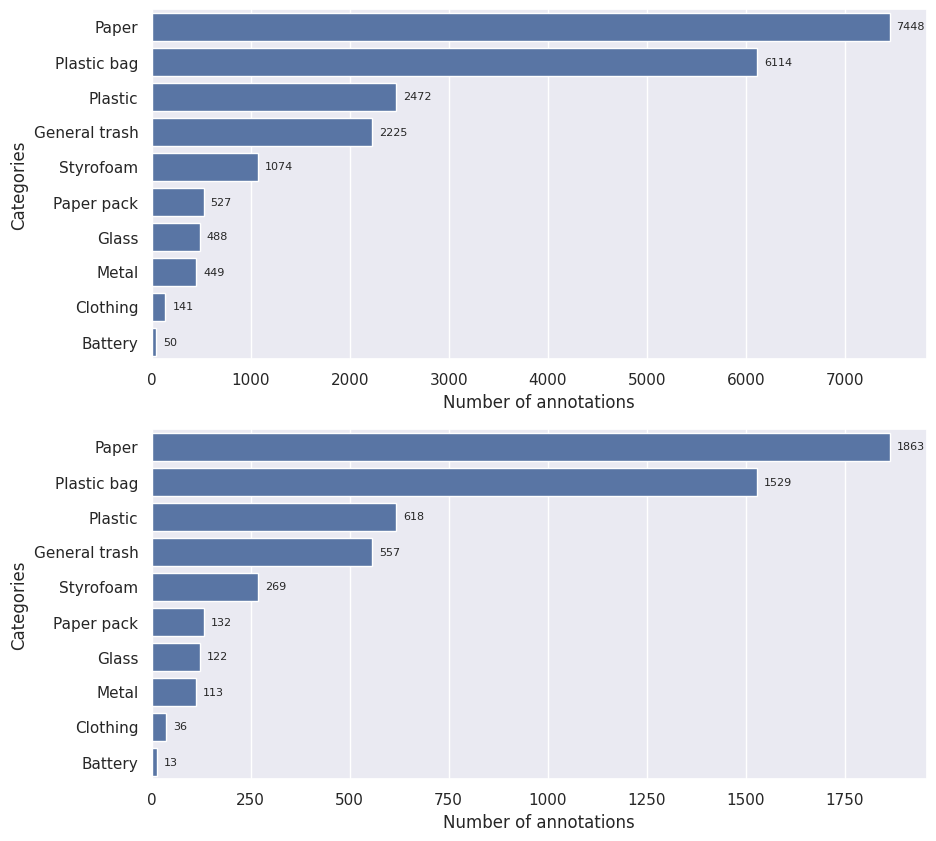

In [5]:
# Initialize the matplotlib figure
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
# Plot the histogram
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=train_df, label="Total", color="b", ax=ax[0])
for p in plot_1.patches: 
    plot_1.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size = 8)   

plot_2 = sns.barplot(x="Number of annotations", y="Categories", data=val_df, label="Total", color="b", ax=ax[1])
for p in plot_2.patches: 
    plot_2.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size = 8)   
    
plt.show()

In [6]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

### Train annotation 분포 확인

In [7]:
coco = COCO(train_anns_file_path)
# label 평균 중앙 좌표
Paper_avg_x = []
Plastic_bag_avg_x = []
Plastic_avg_x = []
General_avg_x = []
Styrofoam_avg_x = []
Paper_pack_avg_x = []
Glass_avg_x = []
Metal_avg_x = []
Clothing_avg_x = []
Battery_avg_x = []

Paper_avg_y = []
Plastic_bag_avg_y = []
Plastic_avg_y = []
General_avg_y = []
Styrofoam_avg_y = []
Paper_pack_avg_y = []
Glass_avg_y = []
Metal_avg_y = []
Clothing_avg_y = []
Battery_avg_y = []

Paper_area = []
Plastic_bag_area = []
Plastic_area = []
General_area = []
Styrofoam_area = []
Paper_pack_area = []
Glass_area = []
Metal_area = []
Clothing_area = []
Battery_area = []

for index in range(len(coco.getImgIds())):
    image_id = coco.getImgIds(imgIds=index)
    image_infos = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)

    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    # Load the categories in a variable
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)
    
    for i in range(len(anns)):
        className = get_classname(anns[i]['category_id'], cats)
        temp_ann_x = anns[i]['bbox'][0] + (anns[i]['bbox'][2] / 2)
        temp_ann_y = anns[i]['bbox'][1] + (anns[i]['bbox'][3] / 2)
        temp_ann_area = anns[i]['area']
        if className == 'Paper':
            Paper_avg_x.append(temp_ann_x)
            Paper_avg_y.append(temp_ann_y)
            Paper_area.append(temp_ann_area)
        elif className == 'Plastic bag':
            Plastic_bag_avg_x.append(temp_ann_x)
            Plastic_bag_avg_y.append(temp_ann_y)
            Plastic_bag_area.append(temp_ann_area)
        elif className == 'Plastic':
            Plastic_avg_x.append(temp_ann_x)
            Plastic_avg_y.append(temp_ann_y)
            Plastic_area.append(temp_ann_area) 
        elif className == 'General trash':
            General_avg_x.append(temp_ann_x)
            General_avg_y.append(temp_ann_y)
            General_area.append(temp_ann_area) 
        elif className == 'Styrofoam':
            Styrofoam_avg_x.append(temp_ann_x)
            Styrofoam_avg_y.append(temp_ann_y)
            Styrofoam_area.append(temp_ann_area) 
        elif className == 'Paper pack':
            Paper_pack_avg_x.append(temp_ann_x)
            Paper_pack_avg_y.append(temp_ann_y)
            Paper_pack_area.append(temp_ann_area) 
        elif className == 'Glass':
            Glass_avg_x.append(temp_ann_x)
            Glass_avg_y.append(temp_ann_y)
            Glass_area.append(temp_ann_area) 
        elif className == 'Metal':
            Metal_avg_x.append(temp_ann_x)
            Metal_avg_y.append(temp_ann_y)
            Metal_area.append(temp_ann_area) 
        elif className == 'Clothing':
            Clothing_avg_x.append(temp_ann_x)
            Clothing_avg_y.append(temp_ann_y)
            Clothing_area.append(temp_ann_area) 
        elif className == 'Battery':
            Battery_avg_x.append(temp_ann_x)
            Battery_avg_y.append(temp_ann_y)
            Battery_area.append(temp_ann_area)
        else:
            print("error", className)
df_Paper = pd.DataFrame({'avg_x': Paper_avg_x, 'avg_y': Paper_avg_y, 'area': Paper_area})
df_Plastic_bag = pd.DataFrame({'avg_x': Plastic_bag_avg_x, 'avg_y': Plastic_bag_avg_y, 'area': Plastic_bag_area})
df_Plastic = pd.DataFrame({'avg_x': Plastic_avg_x, 'avg_y': Plastic_avg_y, 'area': Plastic_area})
df_General = pd.DataFrame({'avg_x': General_avg_x, 'avg_y': General_avg_y, 'area': General_area})
df_Styrofoam = pd.DataFrame({'avg_x': Styrofoam_avg_x, 'avg_y': Styrofoam_avg_y, 'area': Styrofoam_area})
df_Paper_pack = pd.DataFrame({'avg_x': Paper_pack_avg_x, 'avg_y': Paper_pack_avg_y, 'area': Paper_pack_area})
df_Glass = pd.DataFrame({'avg_x': Glass_avg_x, 'avg_y': Glass_avg_y, 'area': Glass_area})
df_Metal = pd.DataFrame({'avg_x': Metal_avg_x, 'avg_y': Metal_avg_y, 'area': Metal_area})
df_Clothing = pd.DataFrame({'avg_x': Clothing_avg_x, 'avg_y': Clothing_avg_y, 'area': Clothing_area})
df_Battery = pd.DataFrame({'avg_x': Battery_avg_x, 'avg_y': Battery_avg_y, 'area': Battery_area})

loading annotations into memory...
Done (t=4.04s)
creating index...
index created!


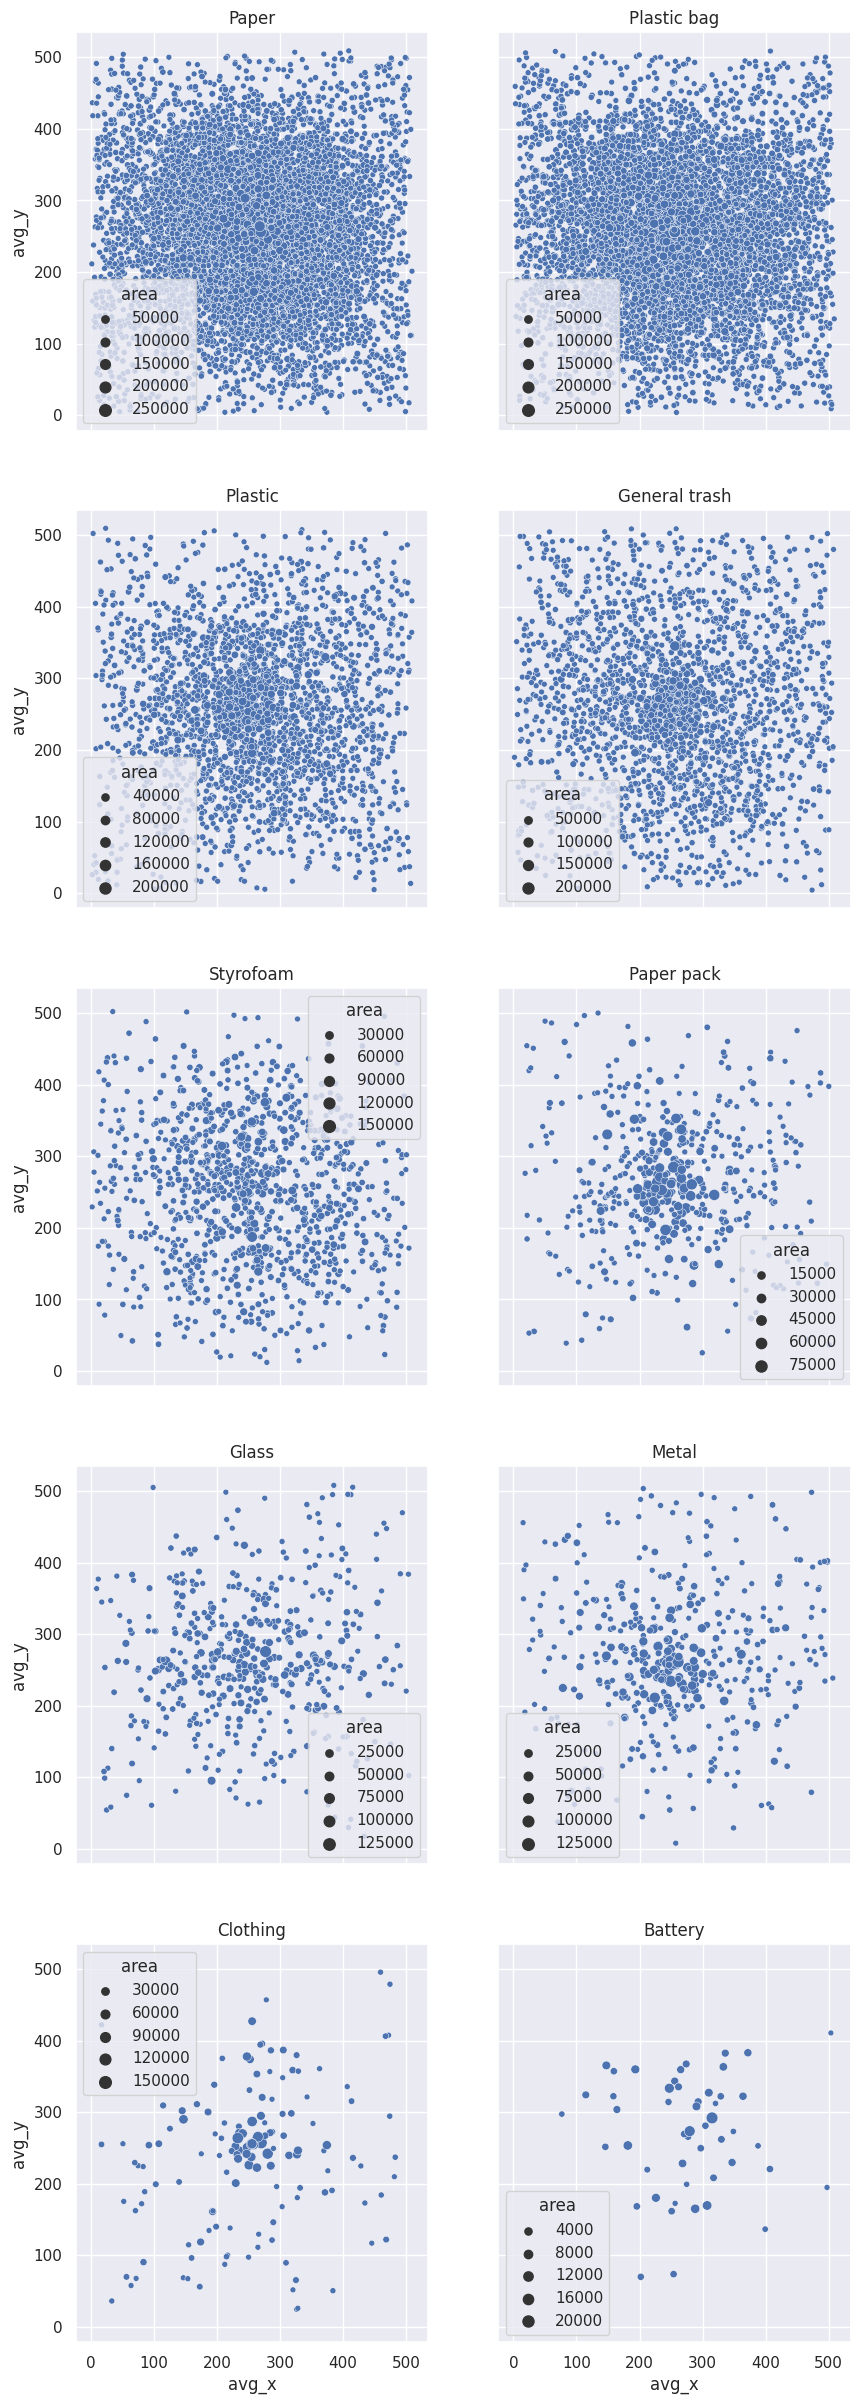

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 30),sharey=True,sharex=True)
axes[0][0].set_title("Paper")
axes[0][0] = sns.scatterplot(data=df_Paper, x='avg_x', y='avg_y', size='area', ax=axes[0][0])
axes[0][1].set_title("Plastic bag")
axes[0][1] = sns.scatterplot(data=df_Plastic_bag, x='avg_x', y='avg_y', size='area', ax=axes[0][1])
axes[1][0].set_title("Plastic")
axes[1][0] = sns.scatterplot(data=df_Plastic, x='avg_x', y='avg_y', size='area', ax=axes[1][0])
axes[1][1].set_title("General trash")
axes[1][1] = sns.scatterplot(data=df_General, x='avg_x', y='avg_y', size='area', ax=axes[1][1])
axes[2][0].set_title("Styrofoam")
axes[2][0] = sns.scatterplot(data=df_Styrofoam, x='avg_x', y='avg_y', size='area', ax=axes[2][0])
axes[2][1].set_title("Paper pack")
axes[2][1] = sns.scatterplot(data=df_Paper_pack, x='avg_x', y='avg_y', size='area', ax=axes[2][1])
axes[3][0].set_title("Glass")
axes[3][0] = sns.scatterplot(data=df_Glass, x='avg_x', y='avg_y', size='area', ax=axes[3][0])
axes[3][1].set_title("Metal")
axes[3][1] = sns.scatterplot(data=df_Metal, x='avg_x', y='avg_y', size='area', ax=axes[3][1])
axes[4][0].set_title("Clothing")
axes[4][0] = sns.scatterplot(data=df_Clothing, x='avg_x', y='avg_y', size='area', ax=axes[4][0])
axes[4][1].set_title("Battery")
axes[4][1] = sns.scatterplot(data=df_Battery, x='avg_x', y='avg_y', size='area', ax=axes[4][1])
plt.show()

### val annotation 분포 확인

In [9]:
coco = COCO(val_anns_file_path)
# label 평균 중앙 좌표
Paper_avg_x = []
Plastic_bag_avg_x = []
Plastic_avg_x = []
General_avg_x = []
Styrofoam_avg_x = []
Paper_pack_avg_x = []
Glass_avg_x = []
Metal_avg_x = []
Clothing_avg_x = []
Battery_avg_x = []

Paper_avg_y = []
Plastic_bag_avg_y = []
Plastic_avg_y = []
General_avg_y = []
Styrofoam_avg_y = []
Paper_pack_avg_y = []
Glass_avg_y = []
Metal_avg_y = []
Clothing_avg_y = []
Battery_avg_y = []

Paper_area = []
Plastic_bag_area = []
Plastic_area = []
General_area = []
Styrofoam_area = []
Paper_pack_area = []
Glass_area = []
Metal_area = []
Clothing_area = []
Battery_area = []

for index in range(len(coco.getImgIds())):
    image_id = coco.getImgIds(imgIds=index)
    image_infos = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)

    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    # Load the categories in a variable
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)
    
    for i in range(len(anns)):
        className = get_classname(anns[i]['category_id'], cats)
        temp_ann_x = anns[i]['bbox'][0] + (anns[i]['bbox'][2] / 2)
        temp_ann_y = anns[i]['bbox'][1] + (anns[i]['bbox'][3] / 2)
        temp_ann_area = anns[i]['area']
        if className == 'Paper':
            Paper_avg_x.append(temp_ann_x)
            Paper_avg_y.append(temp_ann_y)
            Paper_area.append(temp_ann_area)
        elif className == 'Plastic bag':
            Plastic_bag_avg_x.append(temp_ann_x)
            Plastic_bag_avg_y.append(temp_ann_y)
            Plastic_bag_area.append(temp_ann_area)
        elif className == 'Plastic':
            Plastic_avg_x.append(temp_ann_x)
            Plastic_avg_y.append(temp_ann_y)
            Plastic_area.append(temp_ann_area) 
        elif className == 'General trash':
            General_avg_x.append(temp_ann_x)
            General_avg_y.append(temp_ann_y)
            General_area.append(temp_ann_area) 
        elif className == 'Styrofoam':
            Styrofoam_avg_x.append(temp_ann_x)
            Styrofoam_avg_y.append(temp_ann_y)
            Styrofoam_area.append(temp_ann_area) 
        elif className == 'Paper pack':
            Paper_pack_avg_x.append(temp_ann_x)
            Paper_pack_avg_y.append(temp_ann_y)
            Paper_pack_area.append(temp_ann_area) 
        elif className == 'Glass':
            Glass_avg_x.append(temp_ann_x)
            Glass_avg_y.append(temp_ann_y)
            Glass_area.append(temp_ann_area) 
        elif className == 'Metal':
            Metal_avg_x.append(temp_ann_x)
            Metal_avg_y.append(temp_ann_y)
            Metal_area.append(temp_ann_area) 
        elif className == 'Clothing':
            Clothing_avg_x.append(temp_ann_x)
            Clothing_avg_y.append(temp_ann_y)
            Clothing_area.append(temp_ann_area) 
        elif className == 'Battery':
            Battery_avg_x.append(temp_ann_x)
            Battery_avg_y.append(temp_ann_y)
            Battery_area.append(temp_ann_area)
        else:
            print("error", className)
df_Paper = pd.DataFrame({'avg_x': Paper_avg_x, 'avg_y': Paper_avg_y, 'area': Paper_area})
df_Plastic_bag = pd.DataFrame({'avg_x': Plastic_bag_avg_x, 'avg_y': Plastic_bag_avg_y, 'area': Plastic_bag_area})
df_Plastic = pd.DataFrame({'avg_x': Plastic_avg_x, 'avg_y': Plastic_avg_y, 'area': Plastic_area})
df_General = pd.DataFrame({'avg_x': General_avg_x, 'avg_y': General_avg_y, 'area': General_area})
df_Styrofoam = pd.DataFrame({'avg_x': Styrofoam_avg_x, 'avg_y': Styrofoam_avg_y, 'area': Styrofoam_area})
df_Paper_pack = pd.DataFrame({'avg_x': Paper_pack_avg_x, 'avg_y': Paper_pack_avg_y, 'area': Paper_pack_area})
df_Glass = pd.DataFrame({'avg_x': Glass_avg_x, 'avg_y': Glass_avg_y, 'area': Glass_area})
df_Metal = pd.DataFrame({'avg_x': Metal_avg_x, 'avg_y': Metal_avg_y, 'area': Metal_area})
df_Clothing = pd.DataFrame({'avg_x': Clothing_avg_x, 'avg_y': Clothing_avg_y, 'area': Clothing_area})
df_Battery = pd.DataFrame({'avg_x': Battery_avg_x, 'avg_y': Battery_avg_y, 'area': Battery_area})

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


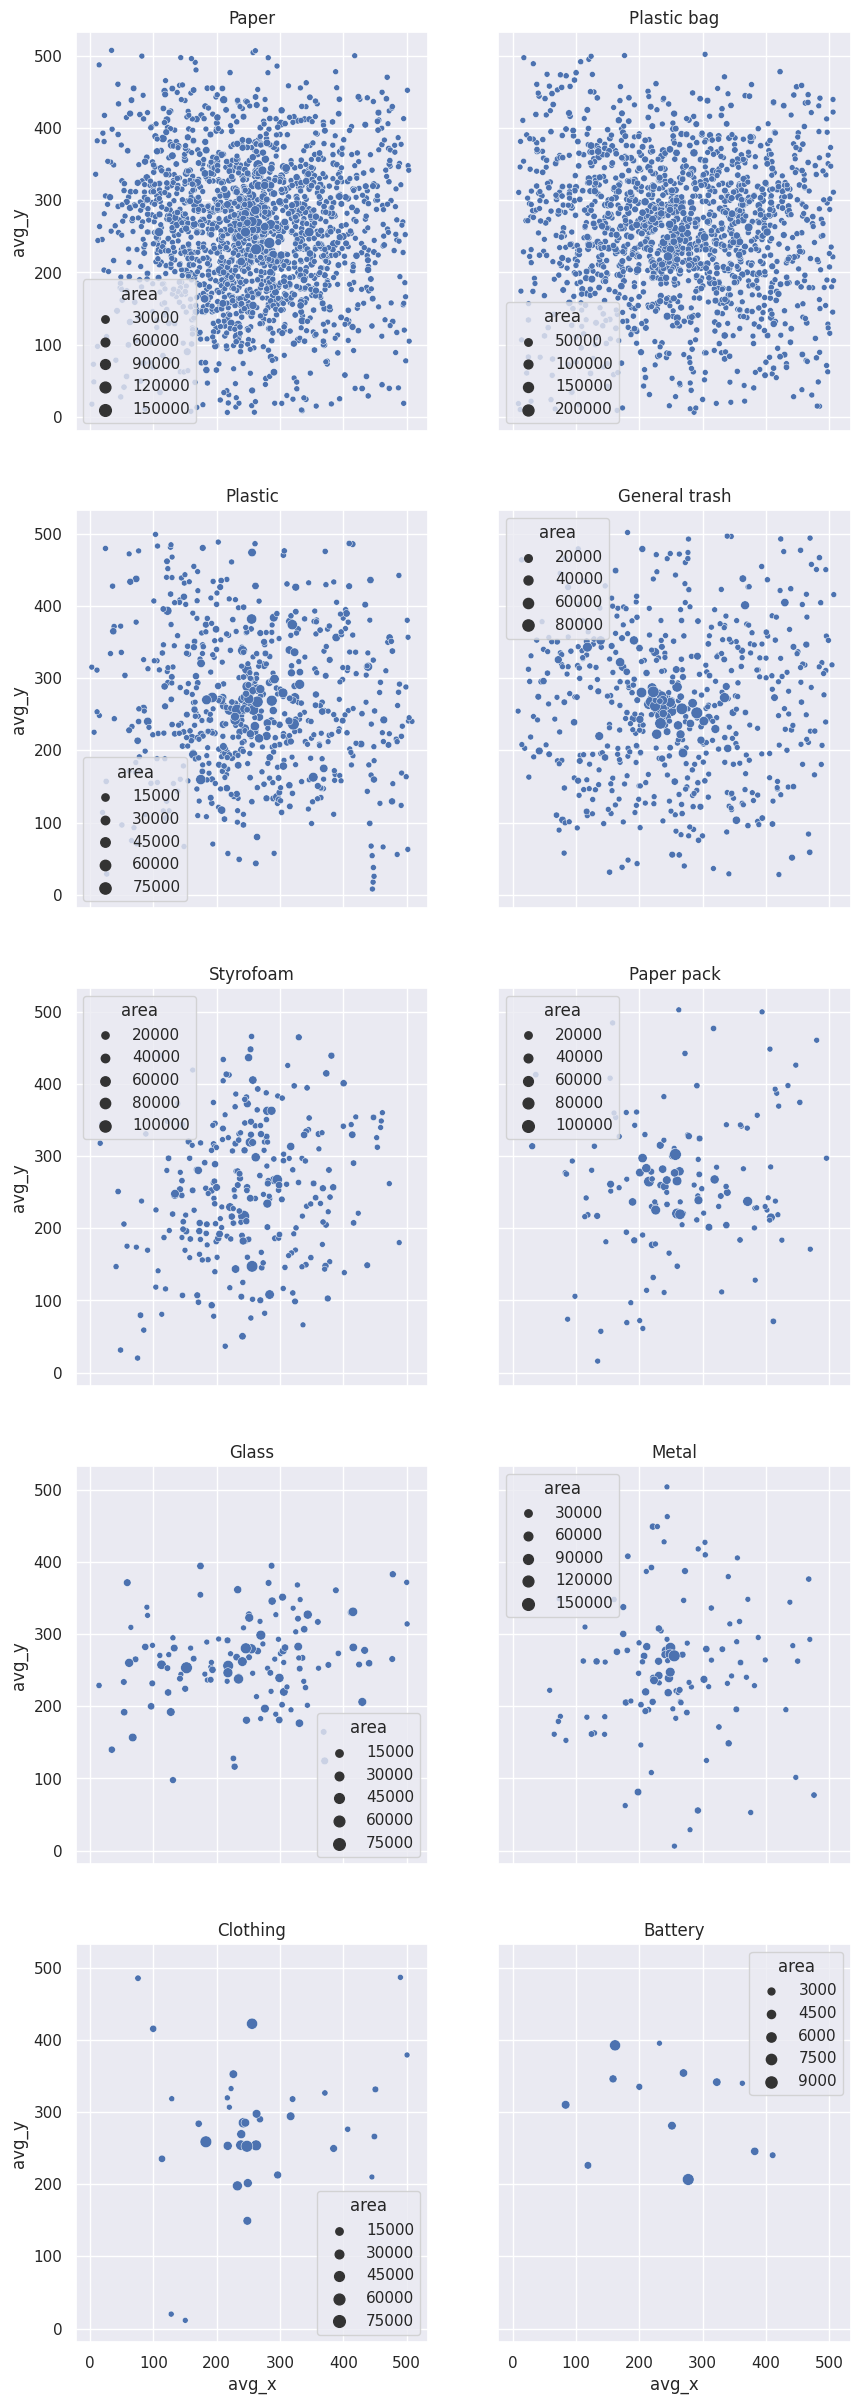

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 30),sharey=True,sharex=True)
axes[0][0].set_title("Paper")
axes[0][0] = sns.scatterplot(data=df_Paper, x='avg_x', y='avg_y', size='area', ax=axes[0][0])
axes[0][1].set_title("Plastic bag")
axes[0][1] = sns.scatterplot(data=df_Plastic_bag, x='avg_x', y='avg_y', size='area', ax=axes[0][1])
axes[1][0].set_title("Plastic")
axes[1][0] = sns.scatterplot(data=df_Plastic, x='avg_x', y='avg_y', size='area', ax=axes[1][0])
axes[1][1].set_title("General trash")
axes[1][1] = sns.scatterplot(data=df_General, x='avg_x', y='avg_y', size='area', ax=axes[1][1])
axes[2][0].set_title("Styrofoam")
axes[2][0] = sns.scatterplot(data=df_Styrofoam, x='avg_x', y='avg_y', size='area', ax=axes[2][0])
axes[2][1].set_title("Paper pack")
axes[2][1] = sns.scatterplot(data=df_Paper_pack, x='avg_x', y='avg_y', size='area', ax=axes[2][1])
axes[3][0].set_title("Glass")
axes[3][0] = sns.scatterplot(data=df_Glass, x='avg_x', y='avg_y', size='area', ax=axes[3][0])
axes[3][1].set_title("Metal")
axes[3][1] = sns.scatterplot(data=df_Metal, x='avg_x', y='avg_y', size='area', ax=axes[3][1])
axes[4][0].set_title("Clothing")
axes[4][0] = sns.scatterplot(data=df_Clothing, x='avg_x', y='avg_y', size='area', ax=axes[4][0])
axes[4][1].set_title("Battery")
axes[4][1] = sns.scatterplot(data=df_Battery, x='avg_x', y='avg_y', size='area', ax=axes[4][1])
plt.show()